### Imports and Utilities

In [ ]:
import textwrap
from copy import deepcopy
from datetime import datetime, timezone
from enum import IntEnum
from math import tau
from typing import Literal, Sequence, Callable

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import xarray as xr
import xarray.ufuncs as xruf
from matplotlib.axes import Axes
from numpy import nan
from scipy.fft import rfft, rfftfreq
from scipy.stats import circmean

from database import HILSuperposition2017Database
from util import AssayType


NUM_VARIABLES = 6
NUM_FFT_VARIABLES = 3
NUM_PARTICIPANTS = 7
NUM_ORDERS = 2
NUM_SAMPLES = 2400
NUM_SAMPLES_FFT = 1201
NUM_SAMPLES_RAW = 2702

BASE_FREQUENCY = 0.05  # Hz - fundamental frequency of stimulus
SAMPLING_FREQUENCY = 60
NYQUIST_FREQUENCY = 0.5 * SAMPLING_FREQUENCY
SAMPLING_PERIOD = 1 / SAMPLING_FREQUENCY
FFT_FREQS = rfftfreq(NUM_SAMPLES, SAMPLING_PERIOD)
FFT_SPACING = SAMPLING_FREQUENCY / NUM_SAMPLES  # Frequency resolution

assay_query_map: dict[Literal['even', 'odd', 'r', 'd'], str] = {
    'even': (
        f"(assay_type == {AssayType.SUM_OF_SINES_R_PLUS_EVEN_D_PLUS_ODD}) | " 
        f"(assay_type == {AssayType.SUM_OF_SINES_R_MINUS_EVEN_D_PLUS_ODD})"
    ),
    'odd': (
        f"(assay_type == {AssayType.SUM_OF_SINES_R_PLUS_ODD_D_PLUS_EVEN}) | "
        f"(assay_type == {AssayType.SUM_OF_SINES_R_MINUS_ODD_D_PLUS_EVEN})"
    ), 
    'r': f"assay_type == {AssayType.SUM_OF_SINES_R_PLUS_ALL_D_ZERO}",
    'd': f"assay_type == {AssayType.SUM_OF_SINES_R_ZERO_D_PLUS_ALL}"
}

def polar_z(r, theta):
    """
    Computes a complex XArray from its polar form.
    """
    
    return r * xr.ufuncs.exp(1j * theta)

def get_trial_data(db: HILSuperposition2017Database, order, participant, type: Literal['even', 'odd', 'r', 'd'],):
    """Helper function to retrieve and organize trial data for a participant."""

    query_expr = f"(order == {order}) & ({assay_query_map[type]}) & (participant_id == b'{participant}')"

    where_list = db.get_where_list(query_expr)    # Hur_r+d stats

    if type == 'even' or type == 'odd':       
        Hur_data = db.tf_reference_to_input[:][where_list]
        Hud_data = db.tf_disturbance_to_input[:][where_list]
        
        return Hur_data, Hud_data
    elif type == 'r':
        Hur_data = db.tf_reference_to_input[:][where_list]

        return Hur_data
    elif type == 'd':
        Hud_data = db.tf_disturbance_to_input[:][where_list]
        return Hud_data
    

# Some jank to precisely calculate these.

vfs = ['fo', 'so']
num_refs = 5
#vf = vfs[order - 1]

np.random.seed(49)
period = 20 # sec
f_base = 1./period # Hz
# TODO go up to 3--5Hz -- check that Sam can track, and check when becomes sub-pixel
primes = np.asarray([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199])
f_max = dict(fo=2,so=1)
p_max = dict([(vf,np.nonzero(primes*f_base <= f_max[vf])[0][-1]) for vf in vfs])

phase_shifts_r = dict([(vf,np.random.rand(num_refs,p_max[vf])) for vf in vfs])

# only first disturbance signal differs from reference signals
phase_shifts_d = deepcopy(phase_shifts_r)
for vf in vfs:
    phase_shifts_d[vf][0] = np.random.rand(p_max[vf])

def get_phase_shifts(vf=None, shift_id=None, signal_type: Literal['reference', 'disturbance']='reference'):
    """
    Returns phase shifts for the given vector field and index.
    
    Args:
        vf (str, optional): Vector field ('fo' or 'so'). If None, returns all.
        shift_id (int, optional): Index of the trial (0 to num_refs-1). If None, returns all.
        signal_type (str): 'reference' or 'disturbance'.
    
    Returns:
        dict or np.ndarray: Phase shifts for the specified parameters.
    """

    if signal_type == 'reference':
        phase_shifts = phase_shifts_r
    elif signal_type == 'disturbance':
        phase_shifts = phase_shifts_d
    else:
        raise ValueError("signal_type must be 'reference' or 'disturbance'")
    
    if vf is None:
        # Return all phase shifts for all vector fields
        return phase_shifts
    elif vf in phase_shifts:
        if shift_id is None:
            # Return all phase shifts for the specified vector field
            return phase_shifts[vf]
        else:
            # Return phase shifts for the specified vector field and shift_id
            return phase_shifts[vf][shift_id]
    else:
        raise ValueError(f"Vector field '{vf}' not found. Available options: {list(phase_shifts.keys())}")


### Timing Stats

Found database cphs2017_pytable.h5
Logs table found in database cphs2017_pytable.h5.
95th percentile: 1.55352


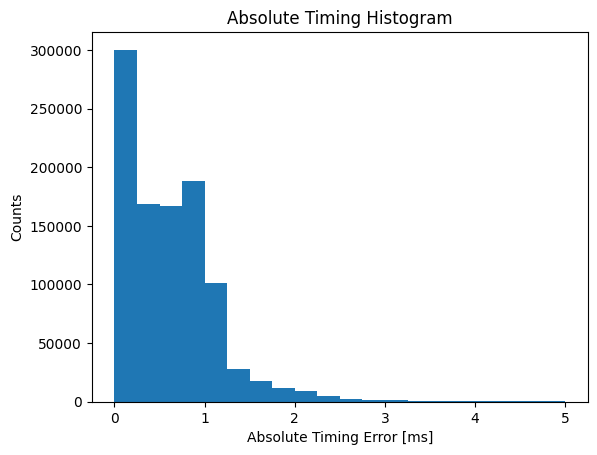

In [ ]:
import matplotlib.pyplot as plt


with HILSuperposition2017Database() as db:
    dt = np.abs(np.diff(db.real_time[:], axis=1) - 1 / 60).flatten()

    plt.title("Absolute Timing Histogram")
    plt.xlabel("Absolute Timing Error [ms]")
    plt.ylabel("Counts")
    plt.hist(1000 * dt, bins=20, range=[0, 5])
    print(f"95th percentile: {np.quantile(1000 * dt, .95):.5f}")

### Store Raw Data into XArray

This takes several seconds...

In [294]:
import xarray as xr

MAX_NUM_TRIALS = 10
NUM_SAMPLES_RAW = 2702
NUM_SAMPLES = 2400

dt = xr.DataTree(
    xr.Dataset(
        coords = {
            'order': np.arange(1, 3),
            'participant': ["dp", "ef", "gy", "iz", "ly", "wv", "zu"],
            'condition': [
                'R_ONLY',
                'D_ONLY',
                'R+EVEN_D+ODD',
                'R+ODD_D+EVEN',
                'R-EVEN_D+ODD',
                'R-ODD_D+EVEN',
            ],
            'trial': np.arange(MAX_NUM_TRIALS),
            'phase_idx': np.arange(11),
            'sample': np.arange(NUM_SAMPLES_RAW),
            'freq': rfftfreq(NUM_SAMPLES, d=SAMPLING_PERIOD),
            'state_var': np.arange(1, 3),
        },
        attrs={
            "FILE_AUTHORS": ["Chow, Ember"],
            "DATA_COLLECTORS": ["Yamagami, Momona"],
            "DATE_CREATED": datetime.now(timezone.utc).isoformat(),
            "STUDY_NAME": "Contributions of feedforward and feedback control in a manual trajectory-tracking task",
            "PROTOCOL_ID": "su7v3",
            "CITATIONS": [
                textwrap.dedent(
                    """
                    @article{YAMAGAMI201961,
                    title = {Contributions of feedforward and feedback control in a manual trajectory-tracking task},
                    journal = {IFAC-PapersOnLine},
                    volume = {51},
                    number = {34},
                    pages = {61-66},
                    year = {2019},
                    note = {2nd IFAC Conference on Cyber-Physical and Human Systems CPHS 2018},
                    issn = {2405-8963},
                    doi = {https://doi.org/10.1016/j.ifacol.2019.01.025},
                    url = {https://www.sciencedirect.com/science/article/pii/S2405896319300278},
                    author = {Momona Yamagami and Darrin Howell and Eatai Roth and Samuel A. Burden},
                    keywords = {internal inverse model, sensorimotor learning, system identification},
                    abstract = {In joint human-cyber-physical systems, the human operator may rely on a combination of reactive (feedback) and predictive (feedforward) control. This paper proposes an experimental and analytical approach to simultaneously identify the human feedback and feedforward controllers in the context of human-cyber-physical systems (HCPS). In our experiments, participants play a 1DOF reference-tracking video game, tasked to guide a cursor to follow a pseudo-random trajectory. For such tasks, the model inversion hypothesis suggests that the human operator would implement as a feedforward controller the inverse of the cyber-physical-system dynamics. Our results indicate that at lower frequencies (≤ 0.15 Hz), individuals capably invert the system dynamics to implement a feedforward controller, but at higher frequencies, the magnitudes of the estimated feedforward transformation are approximately half those of the exact model inverse. This suggests that a frequency limit at which individuals are unable to follow the system dynamics, and thus, the model inversion prediction is only applicable at lower frequencies.}
                    }           
                    """
                ).strip(),
                textwrap.dedent(
                    """
                    @article{9552621,
                    author={Yamagami, Momona and Peterson, Lauren N. and Howell, Darrin and Roth, Eatai and Burden, Samuel A.},
                    journal={IEEE Transactions on Cybernetics}, 
                    title={Effect of Handedness on Learned Controllers and Sensorimotor Noise During Trajectory-Tracking}, 
                    year={2023},
                    volume={53},
                    number={4},
                    pages={2039-2050},
                    keywords={Task analysis;Feedforward systems;Linear systems;Manuals;Linearity;Time-domain analysis;Robot sensing systems;Feedback;feedforward;hand dominance;human-in-the-loop control systems;sensorimotor learning},
                    doi={10.1109/TCYB.2021.3110187}
                    }
                    """
                ).strip()
            ],
            "RANDOM_SEED": 49,
            "TRIM_INDEX": -2400,
            "NUM_SAMPLES": 2400,
            "NUM_SAMPLES_RAW": 2702,
            "NUM_SAMPLES_FFT": 1201,
            "SAMPLING_RATE_HZ": 60,
            "SAMPLING_PERIOD_SECS": 1 / 60,
            "SAMPLING_PERIOD_ERR_SECS_95TH_PERCENTILE": 15.5e-3,
            "BASE_FREQUENCY": 0.05,
            "STIMULUS_FREQS_ORDER1": np.array([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31]),
            "STIMULUS_FREQS_ORDER2":np.array([2, 3, 5, 7, 11, 13, 17]),
            "ORDER1_TRANSFER_FUNCTION": "1 / s",
            "ORDER2_TRANSFER_FUNCTION": "1 / (s^2 + s)",
            'TRIAL_LENGTH_R_ONLY': 10,
            'TRIAL_LENGTH_D_ONLY':  10,
            'TRIAL_LENGTH_R+EVEN_D+ODD':  4,
            'TRIAL_LENGTH_R+ODD_D+EVEN':  2,
            'TRIAL_LENGTH_R+EVEN_D+ODD':  2,
            'TRIAL_LENGTH_R-ODD_D+EVEN':  2,
        }
    ),
    children={
        'data': xr.DataTree(xr.Dataset()),
        'quantiles': xr.DataTree(xr.Dataset(coords={
            'quantile': [0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.95, 0.975, 0.99, 0.995],
        })),
        'means': xr.DataTree(xr.Dataset()),
        "covariances": xr.DataTree(xr.Dataset(coords={
            'cov_i': ['real', 'imag'],
            'cov_j': ['real', 'imag'],
        }))
    } 
)

dt

<xarray.DataTree>
Group: /
│   Dimensions:      (order: 2, participant: 7, condition: 6, trial: 10,
│                     phase_idx: 11, sample: 2702, freq: 1201, state_var: 2)
│   Coordinates:
│     * order        (order) int64 16B 1 2
│     * participant  (participant) <U2 56B 'dp' 'ef' 'gy' 'iz' 'ly' 'wv' 'zu'
│     * condition    (condition) <U12 288B 'R_ONLY' 'D_ONLY' ... 'R-ODD_D+EVEN'
│     * trial        (trial) int64 80B 0 1 2 3 4 5 6 7 8 9
│     * phase_idx    (phase_idx) int64 88B 0 1 2 3 4 5 6 7 8 9 10
│     * sample       (sample) int64 22kB 0 1 2 3 4 5 ... 2697 2698 2699 2700 2701
│     * freq         (freq) float64 10kB 0.0 0.025 0.05 0.075 ... 29.95 29.98 30.0
│     * state_var    (state_var) int64 16B 1 2
│   Attributes: (12/24)
│       FILE_AUTHORS:                              ['Chow, Ember']
│       DATA_COLLECTORS:                           ['Yamagami, Momona']
│       DATE_CREATED:                              2025-08-11T21:33:03.110530+00:00
│       STUDY_NAME:                                Contributions of feedforward a...
│       PROTOCOL_ID:                               su7v3
│       CITATIONS:                                 ['@article{YAMAGAMI201961,\nti...
│       ...                                        ...
│       ORDER2_TRANSFER_FUNCTION:                  1 / (s^2 + s)
│       TRIAL_LENGTH_R_ONLY:                       10
│       TRIAL_LENGTH_D_ONLY:                       10
│       TRIAL_LENGTH_R+EVEN_D+ODD:                 2
│       TRIAL_LENGTH_R+ODD_D+EVEN:                 2
│       TRIAL_LENGTH_R-ODD_D+EVEN:                 2
├── Group: /data
├── Group: /quantiles
│       Dimensions:      (quantile: 12)
│       Coordinates:
│         * quantile     (quantile) float64 96B 0.005 0.01 0.025 ... 0.975 0.99 0.995
├── Group: /means
└── Group: /covariances
        Dimensions:      (cov_i: 2, cov_j: 2)
        Coordinates:
          * cov_i        (cov_i) <U4 32B 'real' 'imag'
          * cov_j        (cov_j) <U4 32B 'real' 'imag'

In [295]:
# Define constants
class AssayType2(IntEnum):
    """
    Codes the assay type as a bit vector using 6 bits.
    Reference information is in 3 most significant bits.
    Disturbance information is in 3 least significant bits.

    In each group of 3 bits, the following information is encoded:

    Bit 1 (MSB): Sign bit (1 is negative and 0 is positive)
    Bit 2: Has even frequencies
    Bit 3: Has odd frequencies
    """

    SUM_OF_SINES_R_PLUS_ALL_D_ZERO = 0b011_000
    SUM_OF_SINES_R_ZERO_D_PLUS_ALL = 0b000_111
    SUM_OF_SINES_R_PLUS_EVEN_D_PLUS_ODD = 0b010_001
    SUM_OF_SINES_R_PLUS_ODD_D_PLUS_EVEN = 0b001_010
    SUM_OF_SINES_R_MINUS_EVEN_D_PLUS_ODD = 0b110_001
    SUM_OF_SINES_R_MINUS_ODD_D_PLUS_EVEN = 0b101_010

NUM_ASSAYS = len(AssayType)
MAX_NUM_PHASES = 11

# Initialize data structure with pre-allocated arrays
data_template: dict[str, np.ndarray] = {
    'collection_timestamps': np.full((NUM_ORDERS, NUM_PARTICIPANTS, NUM_ASSAYS, MAX_NUM_TRIALS), nan, dtype='datetime64[s]'),
    'sign': np.full((NUM_ORDERS, NUM_PARTICIPANTS, NUM_ASSAYS, MAX_NUM_TRIALS), -2, dtype=np.int8),
    'reference_phases': np.full((NUM_ORDERS, NUM_PARTICIPANTS, NUM_ASSAYS, MAX_NUM_TRIALS, MAX_NUM_PHASES), nan),
    'disturbance_phases': np.full((NUM_ORDERS, NUM_PARTICIPANTS, NUM_ASSAYS, MAX_NUM_TRIALS, MAX_NUM_PHASES), nan),
    
#    'time': np.full((NUM_ORDERS, NUM_PARTICIPANTS, NUM_ASSAYS, MAX_NUM_TRIALS, NUM_SAMPLES_RAW), nan),
    'time': np.full((NUM_ORDERS, NUM_PARTICIPANTS, NUM_ASSAYS, MAX_NUM_TRIALS, NUM_SAMPLES_RAW), nan),
    'disturbance': np.full((NUM_ORDERS, NUM_PARTICIPANTS, NUM_ASSAYS, MAX_NUM_TRIALS, NUM_SAMPLES_RAW), nan),
    'reference': np.full((NUM_ORDERS, NUM_PARTICIPANTS, NUM_ASSAYS, MAX_NUM_TRIALS, NUM_SAMPLES_RAW), nan),
    'input': np.full((NUM_ORDERS, NUM_PARTICIPANTS, NUM_ASSAYS, MAX_NUM_TRIALS, NUM_SAMPLES_RAW), nan),
    'state': np.full((NUM_ORDERS, NUM_PARTICIPANTS, NUM_ASSAYS, MAX_NUM_TRIALS, NUM_SAMPLES_RAW, NUM_ORDERS), nan),
    
    'fft_input': np.full((NUM_ORDERS, NUM_PARTICIPANTS, NUM_ASSAYS, MAX_NUM_TRIALS, NUM_SAMPLES_FFT), 1j * nan),
    'fft_reference': np.full((NUM_ORDERS, NUM_PARTICIPANTS, NUM_ASSAYS, MAX_NUM_TRIALS, NUM_SAMPLES_FFT), 1j * nan),
    'fft_disturbance': np.full((NUM_ORDERS, NUM_PARTICIPANTS, NUM_ASSAYS, MAX_NUM_TRIALS, NUM_SAMPLES_FFT), 1j * nan),
    
    'tf_reference_to_input': np.full((NUM_ORDERS, NUM_PARTICIPANTS, NUM_ASSAYS, MAX_NUM_TRIALS, NUM_SAMPLES_FFT), 1j * nan),
    'tf_disturbance_to_input': np.full((NUM_ORDERS, NUM_PARTICIPANTS, NUM_ASSAYS, MAX_NUM_TRIALS, NUM_SAMPLES_FFT), 1j * nan),
}

In [ ]:
with HILSuperposition2017Database() as db:
    for order in range(NUM_ORDERS):
        for participant in range(NUM_PARTICIPANTS):
            for assay_idx, assay in enumerate(AssayType2):
                expr = f"(participant_num=={participant}) & (assay_type=={assay}) & (order == {order + 1})"
                where_list = db.get_where_list(expr)
                
                num_trials = len(where_list)
                if num_trials == 0:
                    continue
                    
                # Load all data for these trials at once
                data_template['collection_timestamps'][order, participant, assay_idx, :num_trials] = \
                    np.floor(db._metadata[where_list]['timestamp']).astype('datetime64[s]')
                
                shift_id = db._metadata[where_list]['phase_shift_id']
                rphases = get_phase_shifts(vf=vf, shift_id=shift_id, signal_type='reference')
                dphases = get_phase_shifts(vf=vf, shift_id=shift_id, signal_type='disturbance')
                
                data_template['reference_phases'][order, participant, assay_idx, :num_trials, :rphases.shape[1]] = rphases
                data_template['disturbance_phases'][order, participant, assay_idx, :num_trials, :dphases.shape[1]] = dphases
                data_template['sign'][order, participant, assay_idx, :num_trials] = db._metadata[where_list]['sign']
                
                # Load time series data
                # data_template['time'][order, participant, assay_idx, :num_trials] = db.raw_time[:][where_list]
                data_template['time'][order, participant, assay_idx, :num_trials] = db.raw_real_time[:][where_list]
                data_template['reference'][order, participant, assay_idx, :num_trials] = db.raw_reference[:][where_list]
                data_template['disturbance'][order, participant, assay_idx, :num_trials] = db.raw_disturbance[:][where_list]
                data_template['input'][order, participant, assay_idx, :num_trials] = db.raw_input[:][where_list]
                
                # Handle state which has variable last dimension
                state = db.raw_state[:][where_list][..., :order + 1]
                data_template['state'][order, participant, assay_idx, :num_trials, :, :order + 1] = state
                
                # Load FFT data
                data_template['fft_reference'][order, participant, assay_idx, :num_trials] = db.fft_reference[:][where_list]
                data_template['fft_disturbance'][order, participant, assay_idx, :num_trials] = db.fft_disturbance[:][where_list]
                data_template['fft_input'][order, participant, assay_idx, :num_trials] = db.fft_input[:][where_list]
                
                # Load transfer functions
                data_template['tf_reference_to_input'][order, participant, assay_idx, :num_trials] = db.tf_reference_to_input[:][where_list]
                data_template['tf_disturbance_to_input'][order, participant, assay_idx, :num_trials] = db.tf_disturbance_to_input[:][where_list]



dt['data'].dataset = dt['data'].dataset.assign(
    collection_timestamp=(('order', 'participant', 'condition', 'trial'), data_template['collection_timestamps']),
    sign=(('order', 'participant', 'condition', 'trial'), data_template['sign']),
    reference_phases=(('order', 'participant', 'condition', 'trial', 'phase_idx'), data_template['reference_phases']),
    disturbance_phases=(('order', 'participant', 'condition', 'trial', 'phase_idx'), data_template['disturbance_phases']),

    #time=(('order', 'participant', 'condition', 'trial', 'sample'), data_template['time']),
    time=(('order', 'participant', 'condition', 'trial', 'sample'), data_template['time']),
    reference=(('order', 'participant', 'condition', 'trial', 'sample'), data_template['reference']),
    disturbance=(('order', 'participant', 'condition', 'trial', 'sample'), data_template['disturbance']),
    input=(('order', 'participant', 'condition', 'trial', 'sample'), data_template['input']),
    state=(('order', 'participant', 'condition', 'trial', 'sample', 'state_var'), data_template['state']),

    fft_reference=(('order', 'participant', 'condition', 'trial', 'freq'), data_template['fft_reference']),
    fft_disturbance=(('order', 'participant', 'condition', 'trial', 'freq'), data_template['fft_disturbance']),
    fft_input=(('order', 'participant', 'condition', 'trial', 'freq'), data_template['fft_input']),

    tf_reference_to_input=(('order', 'participant', 'condition', 'trial', 'freq'), data_template['tf_reference_to_input']),
    tf_disturbance_to_input=(('order', 'participant', 'condition', 'trial', 'freq'), data_template['tf_disturbance_to_input']),
)

# Make the time relative to the 0th sample.
dt['data'].time.loc[:] -= dt['data'].time.loc[dict(sample=0)]

Found database cphs2017_pytable.h5
Logs table found in database cphs2017_pytable.h5.


### Transfer Function Analysis

#### Load data from database

In [ ]:
from itertools import product

data_dims = ['order', 'participant', 'trial', 'freq']

with xr.open_datatree("HILSuperposition-2017.nc4") as _dt:
    dt_data_coords = _dt['data'].coords

data_coords = {dim: dt_data_coords[dim].data for dim in data_dims}

# Frequency analysis parameters

STIM_PRIMES = [
    np.array([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31]),
    np.array([2, 3, 5, 7, 11, 13, 17]),
]

STIM_FREQS = []
STIM_FREQS_EVEN = []
STIM_FREQS_ODD = []
NONSTIM_FREQS = []

for order in range(2):
    # Indices of stimulus frequencies in FFT output
    STIM_IDX = (STIM_PRIMES[order] * BASE_FREQUENCY / FFT_SPACING).astype(int)
    STIM_FREQS.append(FFT_FREQS[STIM_IDX])
    STIM_FREQS_EVEN.append(STIM_FREQS[-1][::2])  # Even-indexed stimulus frequencies
    STIM_FREQS_ODD.append(STIM_FREQS[-1][1::2])   # Odd-indexed stimulus frequencies
    NONSTIM_FREQS.append(FFT_FREQS[np.delete(np.arange(NUM_SAMPLES_FFT), STIM_IDX)])  # Non-stimulus frequencies

def create_data_array(num_trials):
    coord_dict = data_coords | {"trial": range(num_trials)}
    return xr.DataArray(
        data=1j * np.nan, 
        dims=coord_dict.keys(),
        coords=coord_dict,
    )

# r+d are the combined reference and disturbance trials
# r and d are the reference only and disturbance only trials.
NUM_TRIALS = {
    "Hur_r": 10,
    "Hud_d": 10,
    "Hur_r+d_even": 6,
    "Hud_r+d_odd": 6,
    "Hur_r+d_odd": 4,
    "Hud_r+d_even": 4
}

data_arrays = {
    name: create_data_array(num_trials)
    for name, num_trials in NUM_TRIALS.items()  # More explicit iteration
}

with HILSuperposition2017Database() as db:   
    for order, participant in product(data_coords['order'], data_coords['participant']):
        indexer = {'order': order, 'participant': participant}
        
        data_arrays['Hur_r'].loc[indexer] = get_trial_data(db, order, participant, type='r')
        data_arrays['Hud_d'].loc[indexer] = get_trial_data(db, order, participant, type='d')

        data_arrays['Hur_r+d_even'].loc[indexer], data_arrays['Hud_r+d_odd'].loc[indexer] = get_trial_data(db, order, participant, type='even')
        data_arrays['Hur_r+d_odd'].loc[indexer], data_arrays['Hud_r+d_even'].loc[indexer] = get_trial_data(db, order, participant, type='odd')

Found database cphs2017_pytable.h5
Logs table found in database cphs2017_pytable.h5.


#### Analysis Utilities

In [ ]:
with xr.open_datatree("HILSuperposition-2017.nc4") as _dt:
    dt_quantile_coords = _dt['quantiles'].coords
    dt_cov_coords = _dt['covariances'].coords

def split_array(xarr_even: xr.DataArray, xarr_odd: xr.DataArray, order: int):
    """
    Splits an XArray containing raw data into stimulated even, stimulated odd, and nonstimulated frequency arrays.
    """
    
    NONSTIM_SLICE = dict(order=order, freq=NONSTIM_FREQS[order - 1])
    
    return (
        xarr_even.loc[dict(order=order, freq=STIM_FREQS_EVEN[order - 1])],
        xarr_odd.loc[dict(order=order, freq=STIM_FREQS_ODD[order - 1])],
        xr.concat((xarr_even.loc[NONSTIM_SLICE], xarr_odd.loc[NONSTIM_SLICE]), dim='trial'),
    )

def center_phase_mean(tf: xr.DataArray) -> tuple[xr.DataArray, xr.DataArray]:
    """
    Calculates the phase statistics across trials (25th percentile, 50th percentile/median, 75th percentile, and mean) by
    centering the mean angle across trials for each condition at 0, taking the angle, and then rotating the angles back.

    Returns
    -------
    A tuple of (quantiles, mean). 
    """
    
    phase_mean_trial = xr.ufuncs.angle(tf.mean(dim='trial'))

    # Center the mean angle to 0.
    return xr.ufuncs.angle(tf * np.exp(-1j * phase_mean_trial)), phase_mean_trial


def phase_quantiles(tf: xr.DataArray, quantiles, dim):
    """
    Calculates the phase statistics across the given dimension at the specified quantiles.
    """    

    angles, mean = center_phase_mean(tf)
    return angles.quantile(quantiles, dim=dim) + mean



def gain_quantiles(tf: xr.DataArray, quantiles, dim):
    """
    Calculates the gain statistics across trials at the specified quantiles.
    """    

    gains = xr.ufuncs.abs(tf)
    
    return gains.quantile(quantiles, dim=dim)


def gain_phase_quantiles(tf: xr.DataArray, quantiles, dim):
    return gain_quantiles(tf, quantiles, dim), phase_quantiles(tf, quantiles, dim)


def gain_phase_moments(tf: xr.DataArray, dim):
    return gain_moments(tf, dim), phase_moments(tf, dim)


def calculate_quantiles(tf, quantiles, dim):
    return polar_z(*gain_phase_quantiles(tf, quantiles, dim))


def load_covariance(arr: xr.DataArray, tf: xr.DataArray, dim: str):
    arr.loc[dict(cov_i='real', cov_j='real')] = tf.real.var(dim=dim)
    arr.loc[dict(cov_i='imag', cov_j='imag')]= tf.imag.var(dim=dim)

    cov = xr.cov(tf.real, tf.imag, dim=dim)
    arr.loc[dict(cov_i='real', cov_j='imag')] = cov
    arr.loc[dict(cov_i='imag', cov_j='real')] = cov
    

def load_assymetric_quantiles(data: xr.DataArray, tf_split: tuple[xr.DataArray, xr.DataArray, xr.DataArray], quantiles, dim, order):
    for tf, freqs in zip(tf_split, [STIM_FREQS_EVEN[order - 1], STIM_FREQS_ODD[order - 1], NONSTIM_FREQS[order - 1]]):
        data.loc[dict(order=order, freq=freqs)] = calculate_quantiles(tf, quantiles, dim)

def load_assymetric_covariances(data: xr.DataArray, tf_split: tuple[xr.DataArray, xr.DataArray, xr.DataArray], dim, order):
    for tf, freqs in zip(tf_split, [STIM_FREQS_EVEN[order - 1], STIM_FREQS_ODD[order - 1], NONSTIM_FREQS[order - 1]]):
        load_covariance(data.loc[dict(order=order, freq=freqs)], tf, dim)

def load_assymetric_means(data: xr.DataArray, tf_split: tuple[xr.DataArray, xr.DataArray, xr.DataArray], dim, order):
    for tf, freqs in zip(tf_split, [STIM_FREQS_EVEN[order - 1], STIM_FREQS_ODD[order - 1], NONSTIM_FREQS[order - 1]]):
        data.loc[dict(order=order, freq=freqs)] = tf.mean(dim=dim)

def create_xarrays(names, coords):    
    initializer = {
        'data': nan * 1j,
        'dims': coords.keys(),
        'coords': coords,
    }

    return {name: xr.DataArray(**initializer) for name in names}


M_tf = [
    lambda s: 1  / s,
    lambda s: 1 / (s**2 + s)
]

KeyError: 'Could not find node at quantiles'

#### Transfer Function Calculation

In [ ]:
dims = ['order', 'participant', 'freq']
shared_coords = {dim: dt_data_coords[dim].data for dim in dims}
quantiles_coords = {'quantile': dt_quantile_coords['quantile']} | shared_coords
cov_coords = {'cov_i': dt_cov_coords['cov_i'], 'cov_j': dt_cov_coords['cov_j']} | shared_coords

# Same naming scheme as the data arrays
# tf -> transfer 
tf_names = ['Hur_r+d', 'Hur_r', 'Hud_r+d', 'Hud_d', "F_r+d", "F_r", "B_r+d", "B_d"]


tf_quantiles = create_xarrays(tf_names, quantiles_coords)
tf_means = create_xarrays(tf_names, shared_coords)
tf_covariances = create_xarrays(tf_names, cov_coords)
quantiles = quantiles_coords['quantile']

for order in data_coords['order'].data: 
    Hur_r = data_arrays["Hur_r"].loc[dict(order=order)]
    Hud_d = data_arrays["Hud_d"].loc[dict(order=order)]

    Hur_split = split_array(data_arrays['Hur_r+d_even'], data_arrays['Hur_r+d_odd'], order)
    Hud_split = split_array(data_arrays['Hud_r+d_even'], data_arrays['Hud_r+d_odd'], order)

    load_assymetric_quantiles(tf_quantiles['Hur_r+d'], Hur_split, quantiles, dim='trial', order=order)
    load_assymetric_means(tf_means['Hur_r+d'], Hur_split, dim='trial', order=order)
    load_assymetric_covariances(tf_covariances['Hur_r+d'], Hur_split, dim='trial', order=order)

    load_assymetric_quantiles(tf_quantiles['Hud_r+d'], Hud_split, quantiles, dim='trial',order=order)
    load_assymetric_means(tf_means['Hud_r+d'], Hud_split, dim='trial', order=order)
    load_assymetric_covariances(tf_covariances['Hud_r+d'], Hud_split, dim='trial', order=order)

    Hur_rd = tf_means['Hur_r+d'].loc[dict(order=order)] 
    Hud_rd = tf_means['Hud_r+d'].loc[dict(order=order)]

    M = M_tf[order - 1](1j * FFT_FREQS * tau)
    tf_means['F_r+d'].loc[dict(order=order)] = (Hur_rd + Hud_rd / M) / (1 + Hud_rd)
    tf_means['B_r+d'].loc[dict(order=order)] = -Hud_rd / (M * (1 + Hud_rd))

    Hur_r = data_arrays['Hur_r'].loc[dict(order=order)]
    tf_quantiles['Hur_r'].loc[dict(order=order)] = calculate_quantiles(Hur_r, quantiles, dim='trial')
    tf_means['Hur_r'].loc[dict(order=order)] =  Hur_r.mean(dim='trial')
    load_covariance(tf_covariances['Hur_r'].loc[dict(order=order)], Hur_r, dim='trial')


    Hud_d = data_arrays['Hud_d'].loc[dict(order=order)]
    tf_quantiles['Hud_d'].loc[dict(order=order)] = calculate_quantiles(Hud_d, quantiles, dim='trial')
    tf_means['Hud_d'].loc[dict(order=order)] = Hud_d.mean(dim='trial')
    load_covariance(tf_covariances['Hud_d'].loc[dict(order=order)], Hud_d, dim='trial')

    B_d = -Hud_d / (M * (1 + Hud_d))
    tf_quantiles['B_d'].loc[dict(order=order)] = calculate_quantiles(B_d, quantiles, dim='trial')
    tf_means['B_d'].loc[dict(order=order)] = B_d.mean(dim='trial')
    load_covariance(tf_covariances['B_d'].loc[dict(order=order)], B_d, dim='trial')

    F_r = Hur_r * (1 + B_d * M) - B_d
    tf_quantiles['F_r'].loc[dict(order=order)] = calculate_quantiles(F_r, quantiles, dim='trial')
    tf_means['F_r'].loc[dict(order=order)] = F_r.mean(dim='trial')
    load_covariance(tf_covariances['F_r'].loc[dict(order=order)], F_r, dim='trial')

dt['quantiles'].dataset = dt['quantiles'].dataset.assign(
    **{key: value for key, value in tf_quantiles.items()}
)

dt['means'].dataset = dt['means'].dataset.assign(
    **{key: value for key, value in tf_means.items()}
)

dt['covariances'].dataset = dt['covariances'].dataset.assign(
    **{key: value for key, value in tf_covariances.items()}
)

/home/ember/Documents/Work/BioroboticsLab/HSys/CPHS2017/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/ember/Documents/Work/BioroboticsLab/HSys/CPHS2017/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ember/Documents/Work/BioroboticsLab/HSys/CPHS2017/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/home/ember/Documents/Work/BioroboticsLab/HSys/CPHS2017/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/ember/Documents/Work/BioroboticsLab/HSys/CPHS2017/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:86: Runt

#### Save Data

In [ ]:
state_max = dt['data'].state.max()
state_min = dt['data'].state.min()
state_range = 1.5 * (state_max - state_min).data 
state_scale = state_range / (np.iinfo(np.uint16).max - 1)
state_offset = -0.5 * state_range

# 32-bit Floating point precision should be enough for FFTs and transfer functions.
tf_encodings = {tf_name: {'dtype': np.complex64} for tf_name in tf_names}


# Store the data quantized. 
dt.to_netcdf(
    'HILSuperposition-2017.nc4', 
    mode='w',
    encoding={
        '/data': {
            # The input is from a 12 bit precision ADC that got scaled to between -7.5 and 7.5
            'input': {'dtype': np.int16, 'scale_factor': 15 / (np.iinfo(np.uint16).max - 1), '_FillValue': np.iinfo(np.int16).max},

            # 16 bits over 46 seconds is enough for sub-millisecond level precision in timing.
            'time': {'dtype': np.uint16, 'scale_factor': 46 / (np.iinfo(np.uint16).max - 1), '_FillValue': np.iinfo(np.uint16).max},

            # The input is quantized already so we're not really losing anything by quantizing the other variables as well.
            'state': {'dtype': np.uint16, 'scale_factor': state_scale, 'add_offset': state_offset, '_FillValue': np.iinfo(np.uint16).max},
            'reference': {'dtype': np.int16, 'scale_factor': 1 / np.iinfo(np.int16).max, '_FillValue': np.iinfo(np.int16).max},
            'disturbance': {'dtype': np.int16, 'scale_factor': 1 / np.iinfo(np.int16).max, '_FillValue': np.iinfo(np.int16).max},
            
            # 32-bit Floating point precision should be enough.
            'fft_input': {'dtype': np.complex64},
            'fft_reference': {'dtype': np.complex64},
            'fft_disturbance': {'dtype': np.complex64},
            'tf_reference_to_input': {'dtype': np.complex64},
            'tf_disturbance_to_input': {'dtype': np.complex64},
        },
        '/quantiles': tf_encodings,
        '/means': tf_encodings,
        '/covariances': tf_encodings
    },
    auto_complex=True
)

#### $H_{ud}$ and $H_{ur}$ Plots

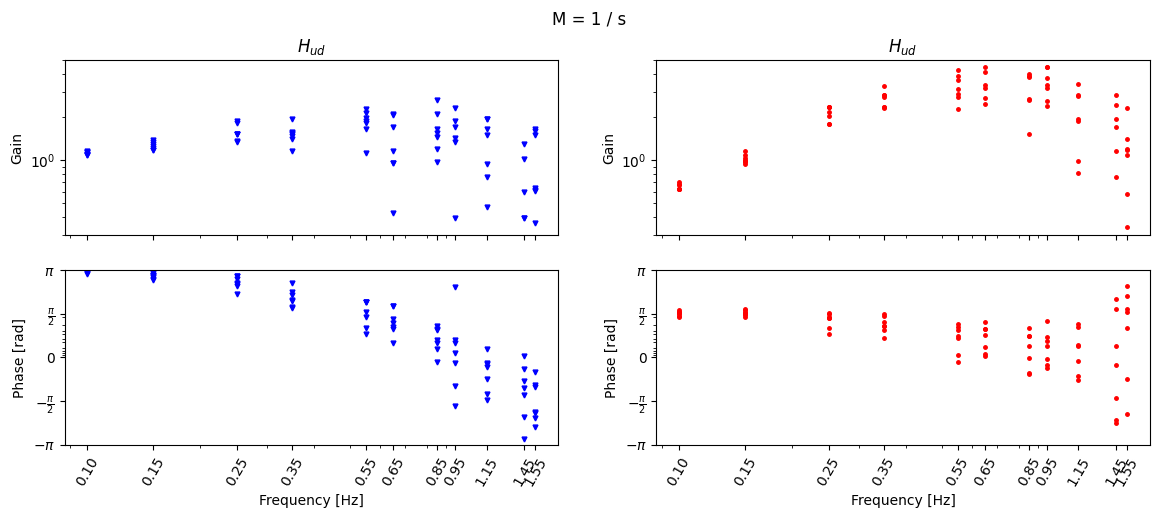

In [6]:
def plot_bode(ax: Sequence[Axes], freqs: Sequence[float], gain: xr.DataArray, phase: xr.DataArray, title: str, gain_lim, fmt: str, markersize: float):
    ax_gain, ax_phase = ax[0], ax[1]

    ax_gain.set_title(title)
    ax_gain.set_ylabel("Gain")

    ax_gain.set_ylim(*gain_lim)
    ax_phase.set_ylim(-0.5 * tau, 0.5 * tau)
    ax_phase.set_ylabel("Phase [rad]")
    ax_phase.set_xlabel("Frequency [Hz]")
    
    ax_gain.sharex(ax_phase)
    ax_gain.tick_params(axis='x', labelbottom=False) 

    for participant in gain.coords['participant'].data:
        ax_gain.loglog(freqs, gain.loc[dict(freq=freqs, participant=participant)], fmt, markersize=markersize)
        ax_phase.plot(freqs, phase.loc[dict(freq=freqs, participant=participant)], fmt, markersize=markersize)

    ax_phase.get_yaxis().set_ticks(freqs, minor=True)
    ax_phase.get_yaxis().set_ticks(
        np.linspace(-0.5 * tau, 0.5 * tau, num=5), 
        labels=[r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$']
    )

    ax_phase.xaxis.set_ticks(freqs)  # Only show ticks at x=1, 3, 5
    ax_phase.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter()) 
    ax_phase.tick_params(axis='x', labelrotation=60)


fig, ax = plt.subplots(2, 2, figsize=(14, 5))
dist_fmt = 'bv'
ref_fmt = 'r.'

plt.suptitle("M = 1 / s")


GAIN_SLICE = dict(order=1)
PHASE_SLICE = dict(order=1, quantile=0.5)

plot_bode(
    ax[:, 0], 
    STIM_FREQS[0],
    xruf.abs(tf_means['Hud_r+d'].loc[GAIN_SLICE]), 
    xruf.angle(tf_quantiles['Hud_r+d'].loc[PHASE_SLICE]), 
    r"$H_{ud}$", (0.3, 5), dist_fmt,  markersize=3.5
)
plot_bode(
    ax[:, 1],
    STIM_FREQS[0],
    xruf.abs(tf_means['Hur_r+d'].loc[GAIN_SLICE]), 
    xruf.angle(tf_quantiles['Hur_r+d'].loc[PHASE_SLICE]), 
    r"$H_{ud}$", (0.3, 5), ref_fmt, markersize=5
)

#plot_bode(ax[:, 1], Hur_rd_gain[-1, 0][:, STIM_FREQS], Hur_rd_phase[1, 0][:, STIM_FREQS],  r"$H_{ur}$", ref_fmt, markersize=5)

#### Feedforward and Feedback Plots

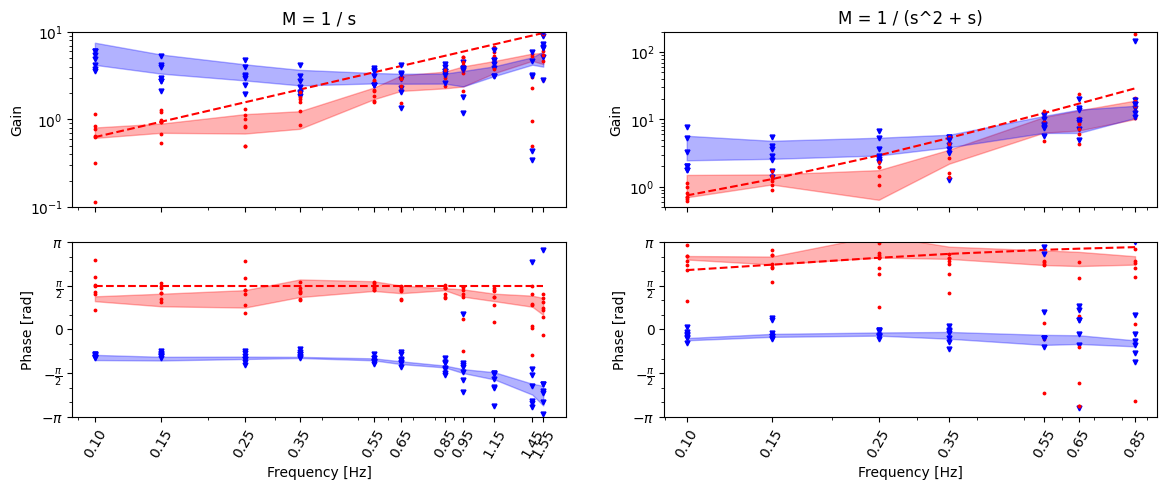

In [101]:
fig, ax = plt.subplots(2, 2, figsize=(14, 5))

f_fmt = 'r.'
b_fmt = 'bv'

def angluar_quantile(arr: xr.DataArray, q: npt.ArrayLike, dim: str):
    angle_mean = xruf.angle(arr.mean(dim=dim))
    arr_rot = arr * xruf.exp(-1j * angle_mean)

    return xruf.angle(arr_rot).quantile(q, dim=dim) + angle_mean


def plot_bode_fb(
        ax: Sequence[Axes], 
        freqs: np.ndarray, 
        M: Callable[[npt.ArrayLike], np.ndarray], 
        F_rd: xr.DataArray, 
        F_r: xr.DataArray, 
        B_rd: xr.DataArray, 
        B_d: xr.DataArray, 
        title: str, 
        gain_lim, fmts: tuple[str, str], 
        markersizes: tuple[float, float]
    ):

    ax_gain, ax_phase = ax[0], ax[1]

    ax_gain.set_title(title)
    ax_gain.set_ylabel("Gain")

    ax_gain.set_ylim(*gain_lim)
    ax_phase.set_ylim(-0.5 * tau, 0.5 * tau)
    ax_phase.set_ylabel("Phase [rad]")
    ax_phase.set_xlabel("Frequency [Hz]")
    
    ax_gain.sharex(ax_phase)
    ax_gain.tick_params(axis='x', labelbottom=False) 

    M_inv = M(1j * freqs * tau)**-1

    gain_phase_rd: list[tuple[xr.DataArray, xr.DataArray]] = [(xruf.abs(F_rd), xruf.angle(F_rd)), (xruf.abs(B_rd), xruf.angle(B_rd))]
    
    F_r_gain_quartiles = xruf.abs(F_r.loc[dict(freq=freqs)]).quantile([0.25, 0.75], dim='participant')
    B_d_gain_quartiles = xruf.abs(B_d.loc[dict(freq=freqs)]).quantile([0.25, 0.75], dim='participant')

    
    F_r_angle_quartiles = angluar_quantile(F_r.loc[dict(freq=freqs)], [0.25, 0.75], dim='participant')
    B_d_angle_quartiles = angluar_quantile(B_d.loc[dict(freq=freqs)], [0.25, 0.75], dim='participant')

    ax_gain.fill_between(freqs, *F_r_gain_quartiles, color='r', alpha=0.3)   
    ax_gain.fill_between(freqs, *B_d_gain_quartiles, color='b', alpha=0.3)   

    ax_phase.fill_between(freqs, *F_r_angle_quartiles, color='r', alpha=0.3)   
    ax_phase.fill_between(freqs, *B_d_angle_quartiles, color='b', alpha=0.3)  

    participants = gain_phase_rd[0][0].coords['participant'].data

    ax_gain.loglog(freqs, np.abs(M_inv), 'r--')
    ax_phase.plot(freqs, np.angle(M_inv), 'r--')

    for participant in participants:
        for fmt, markersize, (gain_rd, phase_rd) in zip(fmts, markersizes, gain_phase_rd):
            ax_gain.loglog(freqs, gain_rd.loc[dict(freq=freqs, participant=participant)], fmt, markersize=markersize)
            ax_phase.plot(freqs, phase_rd.loc[dict(freq=freqs, participant=participant)], fmt, markersize=markersize)
            

    ax_phase.get_yaxis().set_ticks(np.linspace(-0.5 * tau, 0.5 * tau, num=13), minor=True)
    ax_phase.get_yaxis().set_ticks(
        np.linspace(-0.5 * tau, 0.5 * tau, num=5), 
        labels=[r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$']
    )

    ax_phase.xaxis.set_ticks(freqs)  # Only show ticks at x=1, 3, 5
    ax_phase.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter()) 
    ax_phase.tick_params(axis='x', labelrotation=60)


plot_bode_fb(
    ax[:, 0],
    STIM_FREQS[0],
    M_tf[0],
    tf_means['F_r+d'].loc[dict(order=1)],
    tf_means['F_r'].loc[dict(order=1)],
    tf_means['B_r+d'].loc[dict(order=1)],
    tf_means['B_d'].loc[dict(order=1)],
    "M = 1 / s", (0.1, 10), (f_fmt, b_fmt), markersizes=(3.5, 3.5)
)

plot_bode_fb(
    ax[:, 1],
    STIM_FREQS[1],
    M_tf[1],
    tf_means['F_r+d'].loc[dict(order=2)],
    tf_means['F_r'].loc[dict(order=2)],
    tf_means['B_r+d'].loc[dict(order=2)],
    tf_means['B_d'].loc[dict(order=2)],
    "M = 1 / (s^2 + s)", (0.5, 200), (f_fmt, b_fmt), markersizes=(3.5, 3.5)
)

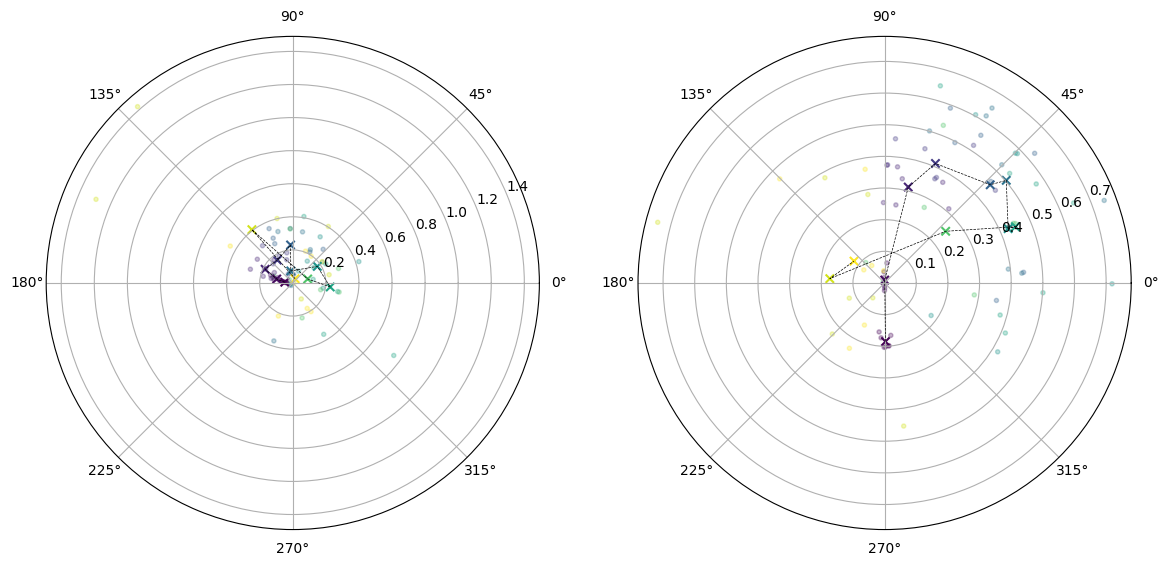

In [88]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.colors import colorConverter


def plot_bode3d(ax: Axes, freqs: Sequence[float], gain: xr.DataArray, phase: xr.DataArray, title: str, gain_lim, fmt: str, markersize: float):
    tf_all = xruf.log10(gain) * xruf.exp(1j * phase)
    ax.set_rorigin(0)
    ax.set_thetamin(0)
    ax.set_rmax(0.5)
    ax.grid(True)

    for participant in gain.coords['participant'].data:
        tf = tf_all.loc[dict(freq=freqs, participant=participant)]
        ax.scatter(np.angle(tf), np.abs(tf), c=freqs, cmap='viridis', marker='.', alpha=0.3)

    tf_mean = tf_all.loc[dict(freq=freqs)].mean(dim='participant')
    ax.scatter(np.angle(tf_mean), np.abs(tf_mean), c=freqs, cmap='viridis', marker='x')
    ax.plot(np.angle(tf_mean), np.abs(tf_mean), 'k--', linewidth=0.5)


fig, ax = plt.subplots(1, 2, figsize=(14, 7), subplot_kw={'projection': 'polar'})

plot_bode3d(
    ax[0], 
    STIM_FREQS[0],
    xruf.abs(tf_means['Hud_r+d'].loc[GAIN_SLICE]), 
    xruf.angle(tf_quantiles['Hud_r+d'].loc[PHASE_SLICE]), 
    r"$H_{ud}$", (0.3, 5), dist_fmt,  markersize=3.5
)

plot_bode3d(
    ax[1], 
    STIM_FREQS[0],
    xruf.abs(tf_means['Hur_r+d'].loc[GAIN_SLICE]), 
    xruf.angle(tf_quantiles['Hur_r+d'].loc[PHASE_SLICE]), 
    r"$H_{ud}$", (0.3, 5), dist_fmt,  markersize=3.5
)
